# Introduction

Trump vs Biden 2020 Presidential Campaign Twitter Sentiment
Introduction
One of the hottest topics in 2020 was the presidential election between Donald J. Trump and former vice president Joe Biden. This election was full of firsts; It was the first election held during a worldwide pandemic, the first election to have 3 states whose margin of victory was under 1%, and the first incumbent president not to concede. Because of the election's uniqueness and the highly contrasting personalities between the candidates, I decided to analyze the sentiment of each candidate’s tweets to find out how much their social media attitude affected their twitter impressions and their general approval.

In the analysis, we mapped the candidate's sentiment in a time series as well as measured how popular their most liked and dislike tweets were through retweets and likes. We wanted to see if there was a correlation between negative or positive sentiment and popularity for each candidate.

We got the motivation for this topic from an article published by Cambridge University Press titled: “Differences in negativity bias underlie variations in political ideology”. This article discusses how negative thoughts gain more attention and popularity than positive thoughts do. Negative thoughts also stay within our memory for a longer period. This also links to negative bias in politics, which triggered an idea to apply sentiment analysis in politics. The 2020 presidential election was the perfect area to focus this analysis on negative political bias. 

# Import Resources
## Read Libraries

In [1]:
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from textblob import TextBlob
import datetime
import re
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lalin90\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lalin90\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Read Data

### Web Scraping

We will get the most recent Trump and Biden tweets by web scraping twitter to obtain tweets from August 2020 - November 2, 2020

The script below gets the 2000 most recent tweets from a twitter account and stores it as a `pkl` file. We will only run it occasionally to control the API requests we make to twitter as they have a limit on how many you can make.

In [2]:
# dont run these 
# AccessToken = '1325166553-AaLqrAHSEzFQg0KOQPrfL5B46EiOuvw3bWV7FUb'
# AccessTokenSecret = 'ahA6V1c7wQoByveazFsq1dcf2YrqccUqbmlPuWCNUJ8Yo'
# API_key = 'BtsZY4DuRx6D6WuYRmyRKc5gr'
# API_key_secret = 'hcqxqk31EzMpKMcRvNdQKDzpGVmsShVlfpX3k1vDXR6zzbIwuJ'
# auth = tweepy.OAuthHandler(API_key,API_key_secret)
# auth.set_access_token(AccessToken, AccessTokenSecret)
# api = tweepy.API(auth)
# user = api.me()
# print(user.name)
#tweets = []
#for page in range(1,10):
#   tweets.extend(api.user_timeline(screen_name = "realDonaldTrump", count=200, page=page))
    
#print("Number of tweets extracted: {}.".format(len(tweets)))

In [3]:
#with open('trump_tweets.pkl', 'wb') as f:
#    pickle.dump(tweets, f)

The `pkl` files will be named `trump_tweets.pkl` and `biden_tweets.pkl` accordingly.

### Import CSV files

We will import the historical twitter data for Trump and Biden from the Kaggle repositories (Up to 8/30/2020)
- https://www.kaggle.com/rohanrao/joe-biden-tweets
- https://www.kaggle.com/codebreaker619/donald-trump-tweets-dataset

We renamed the CSV files to `TrumpOld.csv` and `BidenOld.csv` respectively.


In [4]:
trumpOld = pd.read_csv("./Data/TrumpOld.csv")
bidenOld = pd.read_csv("./Data/BidenOld.csv")

# Data Wrangling

## Exploratory Analysis

First we'll print out 5 tweets to evaluate their format

In [5]:
file = open('./Data/trump_tweets.pkl','rb')
ttweets = pickle.load(file)
for tweet in ttweets[:5]:
    print(tweet.text)

These states in question should immediately be put in the Trump Win column. Biden did not win, he lost by a lot!… https://t.co/w7y0zDaYdL
Big legal win in Pennsylvania!
RT @realDonaldTrump: STOP THE COUNT!
Jobless Claims Dip to 751,000, Lowest Since March https://t.co/dzuJpS78nb via @BreitbartNews
Fmr NV AG Laxalt: ‘No Question‘ Trump Would Have Won Nevada ‘Convincingly‘ Without Mail-in Voting https://t.co/pm4Wpfr6x0 via @BreitbartNews


In [6]:
file = open('./Data/biden_tweets.pkl','rb')
btweets = pickle.load(file)
for tweet in btweets[:5]:
    print(tweet.text)

I extend my deep condolences to the loved ones of the peacekeepers, including 6 American service members, who died… https://t.co/h5ZF41fR9C
RT @Transition46: President-elect Biden spoke this morning with His Holiness Pope Francis. https://t.co/om635SC3M9 https://t.co/DYuiiphOE0
Because of the Affordable Care Act:

- People with pre-existing conditions are protected
- More than 20 million Ame… https://t.co/GglK0KyJe7
Ron Klain’s deep, varied experience and capacity to work with people all across the political spectrum is precisely… https://t.co/KOx0BvNlae
This Veterans Day, I feel the full weight of the honor and the responsibility that has been entrusted to me by the… https://t.co/VjsNzut0R3


We'll also examine the "keys" for each tweet, which are the variables associated with the tweet object. 

We can use twitter's official developer documenation to examine what each variable means:<br>
https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet

In [7]:
ttweets[0].__dict__.keys()

dict_keys(['_json', 'created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source', 'source_url', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'author', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

## Cleaning

### Filter out rewteets

According to the twitter documentation, retweets don't have any content as the point to original user's tweet object, so we will need to remove them.

In [8]:
town_tweets = [tweet for tweet in ttweets if not hasattr(tweet, 'retweeted_status')]
town_tweets[0].text

'These states in question should immediately be put in the Trump Win column. Biden did not win, he lost by a lot!… https://t.co/w7y0zDaYdL'

In [9]:
bown_tweets = [tweet for tweet in btweets if not hasattr(tweet, 'retweeted_status')]
bown_tweets[0].text

'I extend my deep condolences to the loved ones of the peacekeepers, including 6 American service members, who died… https://t.co/h5ZF41fR9C'

### Make DataFrames

We'll make dataframes for Trump and Biden from the `pkl` files.

In [10]:
dfTrump = pd.DataFrame(data = [[tweet.id, tweet.created_at, tweet.text, tweet.favorite_count, tweet.retweet_count] for tweet in town_tweets],
                 columns= ['id', 'date', 'tweet', 'likes', 'retweets'])
print(dfTrump.shape)
dfTrump.tail()

(1424, 5)


,id,date,tweet,likes,retweets
1419,1300170576515026945,2020-08-30 20:36:36,"Ted Wheeler, the wacky Radical Left Do Nothing...",119662,31042
1420,1300041598449917953,2020-08-30 12:04:05,LAW &amp; ORDER!!!,327643,58602
1421,1300038510687260673,2020-08-30 11:51:49,.@DNI_Ratcliffe on @MariaBartiromo this mornin...,44241,8599
1422,1300037695729737733,2020-08-30 11:48:34,Moving along nicely. MAGA! https://t.co/xNchR7...,64511,15949
1423,1300035375751221249,2020-08-30 11:39:21,Michael knows!!! https://t.co/QNuj5Y1PZc,36278,8390


In [11]:
dfBiden = pd.DataFrame(data = [[tweet.id, tweet.created_at, tweet.text, tweet.favorite_count, tweet.retweet_count] for tweet in bown_tweets],
                 columns= ['id', 'date', 'tweet', 'likes', 'retweets'])
print(dfBiden.shape)
dfBiden.tail()

(1661, 5)


,id,date,tweet,likes,retweets
1656,1274785156050464768,2020-06-21 19:24:00,It’s in some of our darkest moments of despair...,46003,15021
1657,1274535081470824451,2020-06-21 02:50:17,Speed up the testing.,245417,33343
1658,1274503550358478850,2020-06-21 00:45:00,I've found that the way to overcome enormous t...,21528,5159
1659,1274486151714353152,2020-06-20 23:35:52,This nation has always strived to serve as a b...,25505,5363
1660,1274467563745865729,2020-06-20 22:22:00,Folks credit me for speaking out on marriage e...,17109,4124


We will also merge the historical tweets data with the recently web scraped tweet data and assure there are no duplicates. We will also need to remove retweets, adjust the column order/names, refactor the date column, and <b>only include data from 4/25/2019 onwards, as that's the date wher Joe Biden was chosen as a presidential candidate.</b>

In [12]:
#Remove retweets
trumpOld = trumpOld.loc[trumpOld.isRetweet == "f" , ["id", "date", "text", "favorites", "retweets"]].copy()
#prepare columns for joining
trumpOld.columns = ["id", "date", 'tweet', 'likes', 'retweets']
#refactor date column to datetime dtype
trumpOld.date = pd.to_datetime(trumpOld.date, infer_datetime_format=True)
#Only include data after april 25, 2019
trumpOld = trumpOld[trumpOld.date >=pd.to_datetime('2019-04-25',  infer_datetime_format=True)]
print(trumpOld.shape)
trumpOld.head()

(7484, 5)


,id,date,tweet,likes,retweets
37742,1.121380e+18,2019-04-25 11:47:00,As has been incorrectly reported by the Fake N...,81100,17408
37743,1.121380e+18,2019-04-25 11:57:00,....Mueller was NOT fired and was respectfully...,101952,21498
37744,1.121390e+18,2019-04-25 12:09:00,.....Despite the fact that the Mueller Report ...,68720,14482
37745,1.121390e+18,2019-04-25 12:22:00,Welcome to the race Sleepy Joe. I only hope yo...,144614,27915
37758,1.121420e+18,2019-04-25 14:35:00,I will be interviewed by @seanhannity tonight ...,58322,12895


In [13]:
#prepare columns for joining
bidenOld = bidenOld.loc[:, ["id", "timestamp", "tweet", "likes", "retweets"]].copy()
#change column names
bidenOld.columns = ["id", "date", 'tweet', 'likes', 'retweets']
#refactor date column to datetime dtype
bidenOld.date = pd.to_datetime(bidenOld.date, infer_datetime_format=True)
#Only include data after april 25, 2019
bidenOld = bidenOld[bidenOld.date >=pd.to_datetime('2019-04-25',  infer_datetime_format=True)]
print(bidenOld.shape)
bidenOld.head()

(3264, 5)


,id,date,tweet,likes,retweets
1341,1.121350e+18,2019-04-25 10:00:00,The core values of this nation… our standing i...,94224,27217
1342,1.121360e+18,2019-04-25 10:39:00,Hoy estoy anunciando mi candidatura para presi...,8720,2487
1343,1.121430e+18,2019-04-25 14:51:00,"Our country is being put to the test, but I’ve...",14918,3286
1344,1.121460e+18,2019-04-25 17:00:00,"Folks, earlier today I announced that I’m runn...",19515,3589
1345,1.121520e+18,2019-04-25 20:45:00,Our campaign is off to a great start thanks to...,12486,2257


Finally we will join the datasets together.

In [14]:
TrumpFinal = trumpOld.append(dfTrump)
print(TrumpFinal.shape)
TrumpFinal.head()

(8908, 5)


,id,date,tweet,likes,retweets
37742,1.121380e+18,2019-04-25 11:47:00,As has been incorrectly reported by the Fake N...,81100,17408
37743,1.121380e+18,2019-04-25 11:57:00,....Mueller was NOT fired and was respectfully...,101952,21498
37744,1.121390e+18,2019-04-25 12:09:00,.....Despite the fact that the Mueller Report ...,68720,14482
37745,1.121390e+18,2019-04-25 12:22:00,Welcome to the race Sleepy Joe. I only hope yo...,144614,27915
37758,1.121420e+18,2019-04-25 14:35:00,I will be interviewed by @seanhannity tonight ...,58322,12895


In [15]:
BidenFinal = bidenOld.append(dfBiden)
print(BidenFinal.shape)
BidenFinal.head()

(4925, 5)


,id,date,tweet,likes,retweets
1341,1.121350e+18,2019-04-25 10:00:00,The core values of this nation… our standing i...,94224,27217
1342,1.121360e+18,2019-04-25 10:39:00,Hoy estoy anunciando mi candidatura para presi...,8720,2487
1343,1.121430e+18,2019-04-25 14:51:00,"Our country is being put to the test, but I’ve...",14918,3286
1344,1.121460e+18,2019-04-25 17:00:00,"Folks, earlier today I announced that I’m runn...",19515,3589
1345,1.121520e+18,2019-04-25 20:45:00,Our campaign is off to a great start thanks to...,12486,2257


### Format Tweets
We use regex to remove any links embedded on Trump's tweets, as some tweets are just a link or retweet of someone else, leading to useless data that skews our calculations, or messes with the sentiment label.


In [16]:
def cleaner(txt):
    txt=re.sub(r'@[A-Za-z0-9]+','',txt)
    txt=re.sub(r'#','',txt)
    txt=re.sub(r'RT[\s]+','',txt)
    txt=re.sub(r'https?:\/\/\S+','',txt)
    txt=re.sub(r'[^\w]', ' ', txt)
    return txt

TrumpFinal['tweet'] = TrumpFinal['tweet'].apply(cleaner)
TrumpFinal = TrumpFinal[TrumpFinal['tweet'] != ""]
print(TrumpFinal.shape)

(8027, 5)


In [17]:
BidenFinal['tweet'] = BidenFinal['tweet'].apply(cleaner)
BidenFinal = BidenFinal[BidenFinal['tweet'] != ""]
print(BidenFinal.shape)

(4921, 5)


Export Clean dataframe for future use.

In [18]:
#TrumpFinal.to_csv("TrumpFinal.csv", index = False)

### Remove small tweets

In [39]:
TrumpFinal

,id,date,tweet,likes,retweets,sentiment,subjectivity,label
37742,1.121380e+18,2019-04-25 11:47:00,As has been incorrectly reported by the Fake N...,81100,17408,-0.003571,0.433929,negative
37743,1.121380e+18,2019-04-25 11:57:00,Mueller was NOT fired and was respectfully...,101952,21498,0.002000,0.648000,positive
37744,1.121390e+18,2019-04-25 12:09:00,Despite the fact that the Mueller Report ...,68720,14482,0.033333,0.666667,positive
37745,1.121390e+18,2019-04-25 12:22:00,Welcome to the race Sleepy Joe I only hope yo...,144614,27915,-0.003571,0.731250,negative
37758,1.121420e+18,2019-04-25 14:35:00,I will be interviewed by tonight at 9 00 PM o...,58322,12895,0.400000,0.500000,positive
37759,1.121450e+18,2019-04-25 16:32:00,Look forward to seeing everyone in Indianapoli...,59012,13372,0.000000,0.000000,neutral
37761,1.121480e+18,2019-04-25 18:09:00,Our Border Control Agents have done an incredi...,78651,18162,0.650000,0.720833,positive
37762,1.121480e+18,2019-04-25 18:11:00,Thank you MAGA,88332,18144,0.000000,0.000000,neutral
37763,1.121580e+18,2019-04-26 00:59:00,I will be interviewed on at 9 00 PM In 5 mi...,52391,7380,0.400000,0.500000,positive
37764,1.121730e+18,2019-04-26 11:12:00,No money was paid to North Korea for Otto Warm...,95833,23286,0.000000,0.000000,neutral


### Add a positve or negative label

In [40]:
TrumpFinal['label'] = 'positive'
TrumpFinal.loc[TrumpFinal['sentiment'] < 0, ['label']] = 'negative'
TrumpFinal.loc[TrumpFinal['sentiment'] == 0, ['label']] = 'neutral'
BidenFinal['label'] = 'positive'
BidenFinal.loc[BidenFinal['sentiment'] < 0, ['label']] = 'negative'
BidenFinal.loc[BidenFinal['sentiment'] == 0, ['label']] = 'neutral'


## Add Sentiment and Subjectivity


We will use the TextBlob library to assign sentiment and subjectivity to tweets.

Test TextBlob

In [19]:
a = TextBlob("Wear your mask")
a.sentiment.polarity

0.0

In [20]:
a = TextBlob("Have a good day")
a.sentiment.polarity

0.7

In [21]:
a = TextBlob("I hate you")
a.sentiment.polarity

-0.8

Sentiment is how positive or negative a sentence is

Sujectivity is how much of an opinion or fact a sentence is (0 is opinion, 1 is fact)

In [22]:
TrumpFinal['sentiment'] = TrumpFinal['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
TrumpFinal['subjectivity'] = TrumpFinal['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.subjectivity)
print(TrumpFinal.shape)
TrumpFinal.head()

(8027, 7)


,id,date,tweet,likes,retweets,sentiment,subjectivity
37742,1.121380e+18,2019-04-25 11:47:00,As has been incorrectly reported by the Fake N...,81100,17408,-0.003571,0.433929
37743,1.121380e+18,2019-04-25 11:57:00,Mueller was NOT fired and was respectfully...,101952,21498,0.002000,0.648000
37744,1.121390e+18,2019-04-25 12:09:00,Despite the fact that the Mueller Report ...,68720,14482,0.033333,0.666667
37745,1.121390e+18,2019-04-25 12:22:00,Welcome to the race Sleepy Joe I only hope yo...,144614,27915,-0.003571,0.731250
37758,1.121420e+18,2019-04-25 14:35:00,I will be interviewed by tonight at 9 00 PM o...,58322,12895,0.400000,0.500000


In [23]:
BidenFinal['sentiment'] = BidenFinal['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
BidenFinal['subjectivity'] = BidenFinal['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.subjectivity)
print(BidenFinal.shape)
BidenFinal.head()

(4921, 7)


,id,date,tweet,likes,retweets,sentiment,subjectivity
1341,1.121350e+18,2019-04-25 10:00:00,The core values of this nation our standing i...,94224,27217,0.2,0.300
1342,1.121360e+18,2019-04-25 10:39:00,Hoy estoy anunciando mi candidatura para presi...,8720,2487,0.0,0.000
1343,1.121430e+18,2019-04-25 14:51:00,Our country is being put to the test but I ve...,14918,3286,0.5,0.500
1344,1.121460e+18,2019-04-25 17:00:00,Folks earlier today I announced that I m runn...,19515,3589,0.0,0.500
1345,1.121520e+18,2019-04-25 20:45:00,Our campaign is off to a great start thanks to...,12486,2257,0.5,0.475


In [25]:
#TrumpFinal.to_csv("TrumpFinal.csv", index = False)

### Get only most Popular Tweets
Since we only care about determining popularity based on sentiment, we'll only use the 50th percentile of tweets based on likes.

In [26]:
tMostLiked = TrumpFinal[TrumpFinal['likes'] >=np.percentile(TrumpFinal.likes, 50)]
#dfMostLiked = dfMostLiked[dfMostLiked['subjectivity'] <= 0.7]
print(tMostLiked.shape)
tMostLiked.head()

(4014, 7)


,id,date,tweet,likes,retweets,sentiment,subjectivity
37742,1.121380e+18,2019-04-25 11:47:00,As has been incorrectly reported by the Fake N...,81100,17408,-0.003571,0.433929
37743,1.121380e+18,2019-04-25 11:57:00,Mueller was NOT fired and was respectfully...,101952,21498,0.002000,0.648000
37745,1.121390e+18,2019-04-25 12:22:00,Welcome to the race Sleepy Joe I only hope yo...,144614,27915,-0.003571,0.731250
37761,1.121480e+18,2019-04-25 18:09:00,Our Border Control Agents have done an incredi...,78651,18162,0.650000,0.720833
37762,1.121480e+18,2019-04-25 18:11:00,Thank you MAGA,88332,18144,0.000000,0.000000


In [27]:
bMostLiked = BidenFinal[BidenFinal['likes'] >=np.percentile(BidenFinal.likes, 50)]
#dfMostLiked = dfMostLiked[dfMostLiked['subjectivity'] <= 0.7]
print(bMostLiked.shape)
bMostLiked.head()

(2461, 7)


,id,date,tweet,likes,retweets,sentiment,subjectivity
1341,1.121350e+18,2019-04-25 10:00:00,The core values of this nation our standing i...,94224,27217,0.2,0.300
1343,1.121430e+18,2019-04-25 14:51:00,Our country is being put to the test but I ve...,14918,3286,0.5,0.500
1344,1.121460e+18,2019-04-25 17:00:00,Folks earlier today I announced that I m runn...,19515,3589,0.0,0.500
1349,1.121920e+18,2019-04-26 23:12:00,I had the privilege to thank one of our grassr...,16895,2124,0.5,0.625
1351,1.122290e+18,2019-04-28 00:19:00,Jill and I are devastated to hear about today ...,39711,5979,0.0,0.000


Since each tweet has an equal weight when determining the days's sentiment polarity, we will round all negative polarity tweets to -1 and all positive polarity tweets to 1, then take the average per day to determine how a day's sentiment is calucalted


## Basic Visualization

Text(0.5, 1.0, 'Daily Average Sentiment')

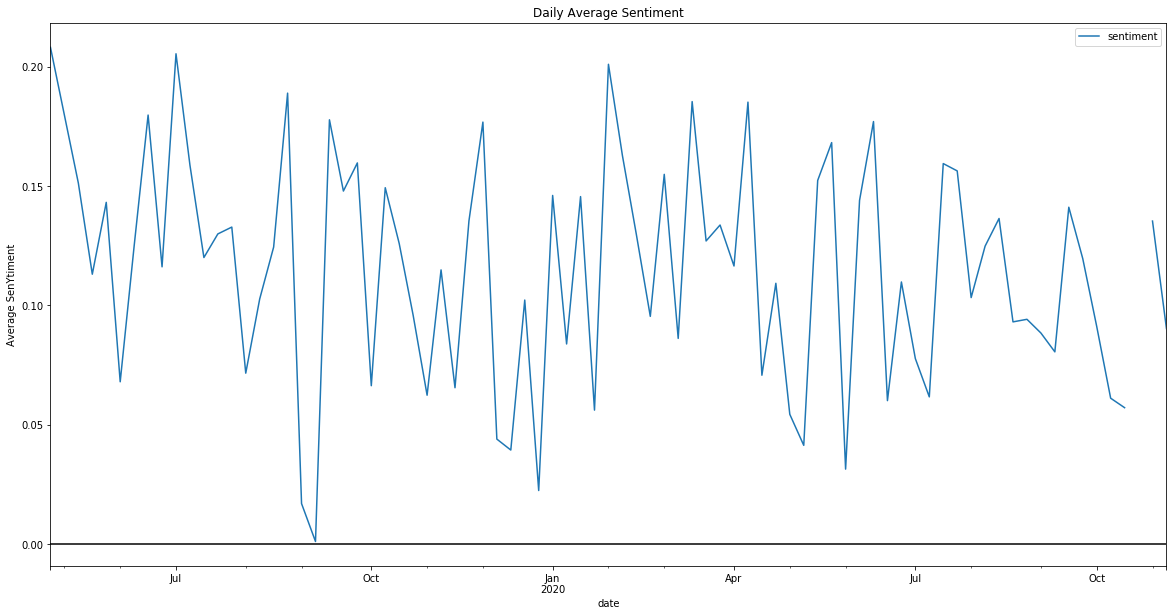

In [28]:
df_date_counts = tMostLiked.groupby([pd.Grouper(key='date', freq='W-MON')]).mean().reset_index()
df_date_counts.plot(kind= 'line', x ='date', y = 'sentiment', figsize = (20,10))
plt.axhline(y=0, color = 'black')
plt.ylabel('Average SenYtiment')
plt.title('Daily Average Sentiment')

Text(0.5, 1.0, 'Daily Average Sentiment')

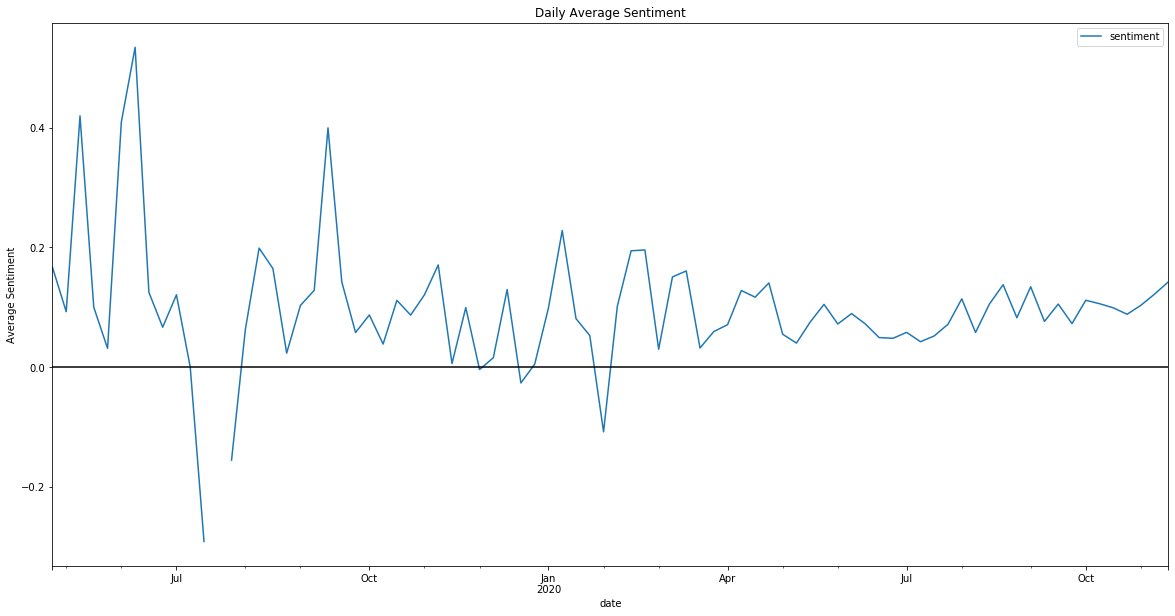

In [29]:
df_date_counts = bMostLiked.groupby([pd.Grouper(key='date', freq='W-MON')]).mean().reset_index()
df_date_counts.plot(kind= 'line', x ='date', y = 'sentiment', figsize = (20,10))
plt.axhline(y=0, color = 'black')
plt.ylabel('Average Sentiment')
plt.title('Daily Average Sentiment')

In [41]:
import plotly.express as px
fig = px.scatter(TrumpFinal, x='sentiment', y='subjectivity', color = 'label')
fig.show()

In [ ]:
From this plot, we can see that the more subjectve